<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering: _Movie Recommendation_

**Key Idea:** Recommend items based on user behavior patterns, not item features.

**Example:** Netflix suggests movies by finding users with similar viewing histories.

**Latent Factors:** Hidden preferences (e.g., genre, era) inferred from data, not explicitly stated.
***

#### **Dataset: MovieLens**
We use a 100k subset of MovieLens, containing:

- `User ID, Movie ID, Rating, Timestamp`

In [1]:
## First Setting up the notebook

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Installing the dependencies
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

## Importing the necessary libraries
from fastbook import *
from fastai.callback.fp16 import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


##### A. Getting Dataset

In [2]:
path = untar_data(URLs.ML_100k)
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/u.user'),Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/ub.base'),Path('/root/.fastai/data/ml-100k/u5.base'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u5.test'),Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/mku.sh'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u.genre')...]

In [3]:
ratings = pd.read_csv(
    path/'u.data', delimiter='\t', header=None,
    names= ['user', 'movie', 'rating', 'timestamp']
)

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
##@ Optional Block....
last_skywalker = np.array([0.98, 0.9, -0.9])
user1 = np.array([0.9, 0.8, -0.6])
(user1 * last_skywalker).sum() ## Getting the dot product

2.1420000000000003

##### B. Creating DataLoaders

In [5]:
#@ Loading  the Movie Titles
movies= pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0,1),
                    names= ('movie', 'title'), header= None)
ratings= ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [6]:
#@ Constructing DataLoaders

dls = CollabDataLoaders.from_df(ratings, item_name= 'title', bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


In [7]:
#@ CONVERTING INTO MATRICES:
n_users = len(dls.classes["user"])
n_movies = len(dls.classes["title"])
n_factors = 5
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [8]:
#@ IMPLEMENTATION OF ONE HOT VECTORS:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

**Embedding:**
- The special layer that indexes into a vector using an integer but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one hot encoded vector is called **Embedding**. Multiplying by a one hot encoded matrix using the computational shortcut that it can be implemented by simply indexing directly. The thing that multiply the one hot encoded matrix is called the **Embedding Matrix**.

##### **1. Introduction to Collaborative Filtering**

Collaborative filtering predicts user preferences by analyzing their interactions with items and comparing them to similar users.

- Example: Movie recommendation systems.
- **Core Idea**: Use a matrix of user-item interactions to learn latent factors for users and items.
- Often modeled as a regression task to predict interaction scores (e.g., ratings).

##### **2. Dot Product Model**





A basic model that computes user-item interaction using the dot product of their latent factors.

In [9]:
#@ Model Definition
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        return (users * movies).sum(dim=1)

In [10]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [11]:
'''
Training:
Using `Learner` from FastAI to train the model.
'''
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.323817,1.340935,00:15
1,1.017078,1.092095,00:07
2,0.873056,0.974699,00:08
3,0.762055,0.897630,00:07
4,0.719645,0.874279,00:07


---

##### **3. Adding Constraints to Predictions**
Real-world interaction scores often have fixed bounds (e.g., movie ratings between 0 and 5). Add constraints using a **sigmoid range**.


In [12]:
#@@ Modified Model
class DotProductWithRange(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1)
        return sigmoid_range(res, *self.y_range)

In [13]:
##@ Training again
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.339878,1.337699,00:07
1,1.049726,1.099613,00:07
2,0.919396,1.007986,00:08
3,0.818623,0.911449,00:10
4,0.793476,0.886434,00:08


---

##### **4. Incorporating User and Movie Bias**
Some users and items exhibit biases:
- Users might rate higher/lower on average.
- Some movies might generally be rated higher/lower.

In [14]:
#@ Model with Bias
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
        return sigmoid_range(res, *self.y_range)

In [15]:
#@ Training again for the model with bias
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.867532,0.946176,00:09
1,0.564744,0.906652,00:10
2,0.418702,0.939039,00:11
3,0.316487,0.951245,00:10
4,0.303472,0.952837,00:08


---

##### **5. Regularization: Weight Decay**
Overfitting occurs when the model fits the training data too well, leading to poor generalization.  
Apply **Weight Decay** (L2 regularization) to reduce this risk.

In [16]:
##@ Training with Weight Decay
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.336025,0.935951,00:08
1,0.372306,0.920442,00:08
2,0.341161,0.905442,00:09
3,0.304106,0.893533,00:10
4,0.288899,0.890320,00:09


---

##### **6. Creating a Custom Embedding Layer**
Instead of using `nn.Embedding`, embeddings can be created manually using `nn.Parameter`.

In [17]:
##@ Custom Embedding Model

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBiasCustom(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.movie_factors = create_params([n_movies, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users * movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [18]:
##@ Training the Custom Embedded Model
model = DotProductBiasCustom(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.878707,0.940981,00:09
1,0.676217,0.885803,00:09
2,0.512723,0.869106,00:11
3,0.457896,0.857801,00:10
4,0.444701,0.853635,00:09


---
##### **7. Interpreting Embeddings and Biases**

The model parameters provide insights into user preferences and item characteristics. The bias terms are the easiest to interpret:
<ul>
<b>Movie Bias Analysis:</b>
The <code>movie_bias</code> indicates whether people generally like or dislike a movie, irrespective of its latent factors.
</ul>

In [20]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]  # Movies with the lowest bias
[dls.classes['title'][i] for i in idxs]

['Showgirls (1995)',
 'Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Grease 2 (1982)',
 'Island of Dr. Moreau, The (1996)']

<details>
<summary>
<b>Key Insight</b>
</summary>
<ul>
These movies have low bias scores, meaning users dislike them even if their latent factors match the user’s preferences.
</ul>
</details>

In [21]:
#@ Movies with High Bias:

idxs = movie_bias.argsort(descending=True)[:5]  # Movies with the highest bias
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Rear Window (1954)']

These movies are liked even by users who don't typically prefer their genre.

---

##### **8. Understanding Embedding Models**

Embedding matrices are harder to interpret directly. Using Principal Component Analysis (PCA), we can visualize movies along dominant dimensions. PCA highlights patterns, such as "classic vs. pop culture" or "critically acclaimed vs. popular."

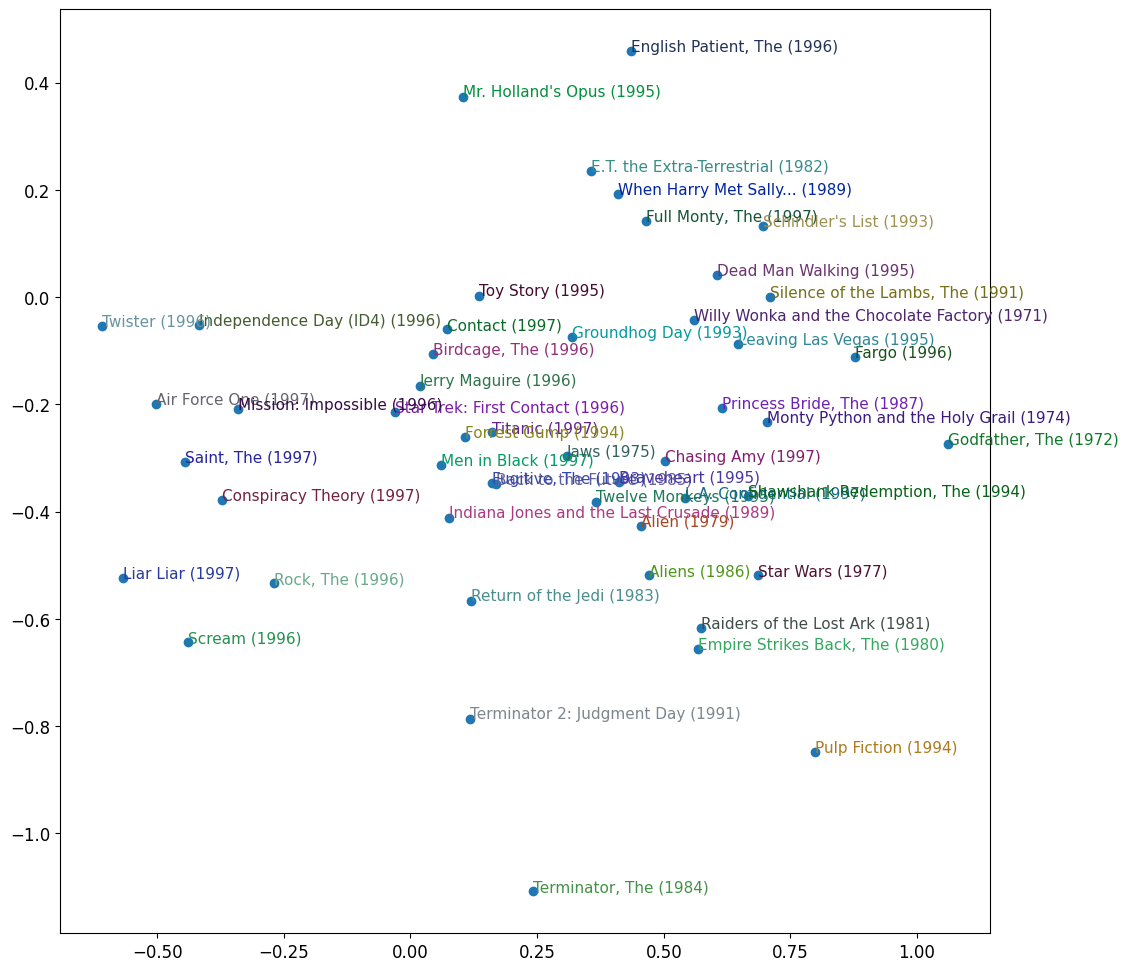

In [23]:
#@ REPRESENTATION OF MOVIES BASED ON PCA:
g = ratings.groupby("title")["rating"].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes["title"].o2i[m] for m in \
                   top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))
X, Y = fac0[idxs], fac2[idxs]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

---
##### **9. Collaborative Filtering Using FastAI**

In [24]:
#@ IMPLEMENTATION OF COLLAB LEARNER:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.838230,0.940607,00:08
1,0.675711,0.886384,00:10
2,0.556865,0.871163,00:10
3,0.448129,0.853011,00:09
4,0.441567,0.849666,00:08


In [25]:
##@ Inspecting layers of the learner
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [26]:
#@ GETTING MOVIES WITH HIGHEST BIASES:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes["title"][i] for i in idxs]

['Titanic (1997)',
 'Rear Window (1954)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Star Wars (1977)']

---
##### **10. Embedding Distance**

Embedding similarity can be used to identify similar movies based on user preferences:

In [27]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Priest (1994)'

This identifies movies similar to _Silence of the Lambs_ based on embedding distances.

---

##### **11. Bootstraping Collaborative Filtering Models**

The **bootstrap problem** arises when dealing with new users or items. Possible solutions include:

- Assign the average embedding vector of existing users/items.
- Pick a representative "average taste" user.
- Use metadata or survey data to create initial embeddings.

**Challenges to Address:**
- Representation bias: Certain groups (e.g., anime enthusiasts) may skew recommendations.
- Positive feedback loops: Amplification of biases through repeated user interaction.

**Action Plan:**
- Monitor the system for feedback loops.
- Ensure human oversight and gradual rollouts.

---


##### **12. Deep Learning for Collaborative Filtering**

To enhance collaborative filtering, the embeddings can be passed through a neural network. Instead of taking a dot product, embeddings are concatenated and fed into linear layers.

In [28]:
#@ Embedding matrix sizes
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [29]:
##@ Implementation of CollabNN

class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [30]:
#@ Training the model
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.924072,0.943780,00:09
1,0.863517,0.912208,00:09
2,0.802518,0.879978,00:09
3,0.793908,0.861309,00:09
4,0.745720,0.858373,00:08


##### **13. Using `fastai.collab` for Deep Learning**

In [31]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.978749,0.969442,00:12
1,0.915267,0.917536,00:12
2,0.833161,0.884573,00:12
3,0.781387,0.861286,00:14
4,0.736133,0.857742,00:10


In [32]:
###@ Model Structure
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=0, high=5.5)
  )
)

Fastai uses `EmbeddingNN`, which inherits from `TabularModel`, to manage embeddings and layers efficiently.

---
##### **14. Handling Keyword Arguments with `@delegates`**

Fastai's `@delegates` decorator improves API usability by delegating arguments to parent functions/classes, preserving functionality while enhancing clarity in Jupyter.

In [33]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1,**kwargs)

---
###### **Optional: `kwargs` related notes:**

**1. What is `kwargs`?**
- It collects extra keyword arguments (parameters with names) into a dictionary.

**2. Why use it?**
- To handle optional or additional parameters without explicitly listing them.

**3. How to use `kwargs`?**
- Define a function or class with `kwargs` in the parameter list.
- The arguments are stored as key-value pairs in a dictionary.

In [34]:
#### Example 1: Using `**kwargs` in a Function

# Define a function with **kwargs
def show_details(**kwargs):
    # kwargs is a dictionary
    for key, value in kwargs.items():
        print(f"{key}: {value}")

# Call the function with extra arguments
show_details(name="Alice", age=25, city="New York")

name: Alice
age: 25
city: New York


In [35]:
#### Example 2: Passing a Dictionary with `**kwargs`

# Pre-defined dictionary
data = {"hobby": "painting", "skill": "coding"}

# Passing the dictionary using **kwargs
show_details(**data)

hobby: painting
skill: coding


**Key Notes**
1. ` **kwargs ` collects extra **keyword arguments** into a dictionary.
2. ` **kwargs ` (when used in a function call) unpacks a dictionary into arguments.
3. **Use case**: Flexibility for handling optional or unknown arguments.

---
The End of Chapter

---